# **GWU Doctoral Cyber Security Alaytics: Praxis Research**

# **A Holistic Approach to Enable Dynamic Policy Management for Zero Trust Architecure Implementations**

## Jody Spearing

## July 2025

## V3.5

## --------------------------------------------------------------------------------
##  **Supervised Clustering Overview**


**Section 1:** Create Running Environment
*   Install / Import Libraries
*   Validate Runtime
* Load Data: create dataframe = df_0

**Section 2:** Basic Data Exploration on df_0

**Section 3:** Preprocessing on df_1

**Section 4:** Functions

**Section 5:** Model Creation Defined Clusters

**Section 6:** Calculate Metrics

**Section 7:** Display Visualizations

**Section 8:** Analyze Results

# **Section 1: Install / Import Libraries**

In [ ]:
######################################################################################################################
## Install Python libraries
######################################################################################################################

#!apt-get -y install cuda
#!pip install pycuda # Moved before cuda-python
#!pip install cuda-python
#!pip install cudf-cu11
#!pip install rmm

# Install RAPIDS (cuML) for GPU-accelerated KMeans
#!pip install -q --extra-index-url=https://pypi.nvidia.com cuml-cu11 dask-cuda --upgrade


In [ ]:
######################################################################################################################
## Import Python libraries
######################################################################################################################
# Base Libraries
import pandas as pd
import numpy as np
import time
import os
from google.colab import drive
import logging
import warnings
warnings.filterwarnings('ignore')
from scipy.io import arff

# Performance Enhancement Libraries
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
import torch
import cupy as cp

from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample

# Preprocessing Libraries
from sklearn.cluster import KMeans
#from cuml import KMeans as cuKMeans
#from cuml.metrics import silhouette_score as gpu_silhouette_score
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

#Clustering Metrics Libraries
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix

# **Section 1: Validate Runtime**

In [ ]:
######################################################################################################################
# Get GPU info
# Run the 'nvidia-smi' command to get GPU status information.
# The '!' syntax is used in environments like Jupyter Notebooks to execute shell commands.
# Join the output list into a single string separated by newline characters.
# Check if the word 'failed' appears in the output, which may indicate no GPU is connected or accessible.
# Inform the user that no GPU is connected.
# Otherwise, print the GPU information retrieved.
######################################################################################################################

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 28 12:16:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             43W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
######################################################################################################################
# Get memory info
# Import the virtual_memory function from the psutil module
# psutil is a cross-platform library for retrieving system information like CPU, memory, disks, etc.
# Get the total available RAM in bytes and convert it to gigabytes by dividing by 1e9 (1,000,000,000)
# Print the amount of available RAM with one decimal place

# Check if the available RAM is less than 20 GB
# If so, inform the user that this is not a high-RAM runtime
# Otherwise, inform the user they are using a high-RAM runtime
######################################################################################################################

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
######################################################################################################################
# Check GPU
# Check if a CUDA-compatible GPU is available using PyTorch
# ✅ If a GPU is available, print the name of the first GPU device
# Print the amount of memory currently allocated on the GPU in gigabytes

# Print the amount of memory reserved by the PyTorch caching allocator in gigabytes
# ❌ If no GPU is available, inform the user
######################################################################################################################

if torch.cuda.is_available():
    print("✅ GPU is available:", torch.cuda.get_device_name(0))
    print("Memory allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 2), "GB")
    print("Memory reserved:", round(torch.cuda.memory_reserved(0)/1024**3, 2), "GB")
else:
    print("❌ No GPU found")

✅ GPU is available: NVIDIA A100-SXM4-40GB
Memory allocated: 0.0 GB
Memory reserved: 0.0 GB


In [ ]:
######################################################################################################################
# Environment Setup
# Set Logging
# Set Utilization to 90-100% during training
######################################################################################################################

logging.basicConfig(level=logging.INFO)
!nvidia-smi

Mon Apr 28 12:17:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             43W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# **Section 1: Load Data: Original Dataframe = df_0**

In [ ]:
######################################################################################################################
# get / set working directory
# List Contents of working directory
######################################################################################################################

drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive"

Mounted at /content/gdrive
'Colab Notebooks'	     IMG_0001.jpg
 GWU			     IMG_0006.jpg
'GWU Praxis Notebook HTML'  'Jody Spearing Statement 04-25-2025.gdoc'


In [ ]:
######################################################################################################################
# Load Data file into dataframe 'df_0' denoting original
# Define the path to the Google Drive directory where the dataset is stored
# Define the name of the dataset file
# Combine the path and filename into a full path to the data file
# Optional: Limit the number of rows read for testing large files (commented out)
# nRowsRead = 1000000  # used for testing
# Read the CSV file into a pandas DataFrame
# Optionally, you could use nrows=nRowsRead for testing large datasets
# Print the first few rows of the DataFrame to verify that the file was read correctly
# Handle case where the file path is incorrect or file is missing
# Handle case where the CSV file has formatting issues and can't be parsed
# Catch any other unexpected exceptions and print the error message
######################################################################################################################

drive_path = '/content/gdrive/My Drive/GWU/Praxis/data/'
data = 'Dataset-Unicauca-Version2-87Atts 2.csv'
user_data = 'User Groups Dataset-131atts.arff'
data_file = drive_path + data
user_data_file = drive_path + user_data
#nRowsRead = 1_500_000

try:
  #df_0 = pd.read_csv(data_file, nrows = nRowsRead)
  #df_0 = pd.read_csv(data_file)
  #print(df_0.head()) # Print the first few rows to verify

  # Sample rows
  #data_sampled = df.sample(n=nRowsRead, random_state=42)

except FileNotFoundError:
  print(f"Error: File not found at {data_file}")
except pd.errors.ParserError:
    print(f"Error: Unable to parse the file at {data_file}. Check file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

# **Section 2: Basic Data Exploration on df_0**

In [ ]:
######################################################################################################################
# Basic Data Exploration
# Print the shape of the dataset (rows, columns)
# Print concise summary of the DataFrame: column names, non-null counts, and data types
# Print descriptive statistics for numeric columns (count, mean, std, min, etc.)
# Print the list of column names
# Print the first 5 rows of the dataset
# Print the last 5 rows of the dataset
# Print the count of missing (null) values for each column
# Print the number of duplicated rows in the dataset
# Print the number of unique values for each column
# Print the data type of each column
# Print the memory usage of each column
######################################################################################################################

print('------------------------------------------------------------')
print('DATASET SHAPE')
print('------------------------------------------------------------')
print(df_0.shape)
print('------------------------------------------------------------')
print('DATASET INFO')
print('------------------------------------------------------------')
print(df_0.info())
print('------------------------------------------------------------')
print('DATASET DESCRIBE')
print('------------------------------------------------------------')
print(df_0.describe())
print('------------------------------------------------------------')
print('DATASET COLUMNS')
print('------------------------------------------------------------')
print(df_0.columns)
print('------------------------------------------------------------')
print('DATASET HEAD')
print('------------------------------------------------------------')
print(df_0.head())
print('------------------------------------------------------------')
print('DATASET TAIL')
print('------------------------------------------------------------')
print(df_0.tail())
print('------------------------------------------------------------')
print('DATASET NULL VALUES')
print('------------------------------------------------------------')
print(df_0.isnull().sum())
print('------------------------------------------------------------')
print('DATASET DUPLICATE VALUES')
print('------------------------------------------------------------')
print(df_0.duplicated().sum())
print('------------------------------------------------------------')
print('DATASET UNIQUE VALUES')
print('------------------------------------------------------------')
print(df_0.nunique())
print('------------------------------------------------------------')
print('DATASET DATA TYPES')
print('------------------------------------------------------------')
print('dataset dtypes = ',df_0.dtypes)
print('------------------------------------------------------------')
print('DATASET MEMORY USAGE')
print('------------------------------------------------------------')
print(df_0.memory_usage())
print('------------------------------------------------------------')


------------------------------------------------------------
DATASET SHAPE
------------------------------------------------------------
(3577296, 87)
------------------------------------------------------------
DATASET INFO
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577296 entries, 0 to 3577295
Data columns (total 87 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow.ID                      object 
 1   Source.IP                    object 
 2   Source.Port                  int64  
 3   Destination.IP               object 
 4   Destination.Port             int64  
 5   Protocol                     int64  
 6   Timestamp                    object 
 7   Flow.Duration                int64  
 8   Total.Fwd.Packets            int64  
 9   Total.Backward.Packets       int64  
 10  Total.Length.of.Fwd.Packets  int64  
 11  Total.Length.of.Bwd.Packets  float64
 12  Fwd.Packe

In [ ]:
######################################################################################################################
# Create copy of clean data to avoid reloading
######################################################################################################################

data = df_0.copy()

# **Section 3: Preprocessing on df_1**

In [ ]:

######################################################################################################################
# Add labels for groups of ProtocolName
# Define the mapping for protocol categories
# Reverse the mapping for easier lookup
# Data is the DataFrame
# Add a new column 'label' based on the 'ProtocolName'
######################################################################################################################

protocol_categories = {
    'Authenticated Browse': ['SSL', 'SSL_NO_CERT'],
    'Browse': ['HTTP', 'HTTP_PROXY', 'HTTP_CONNECT', 'HTTP_DOWNLOAD', 'TOR', 'CONTENT_FLASH'],
    'Cloud Storage': ['DROPBOX', 'MS_ONE_DRIVE', 'APPLE_ICLOUD', 'UBUNTUONE'],
    'File Transfer & Streaming': ['FTP_DATA', 'EDONKEY', 'FTP_CONTROL', 'BITTORRENT', 'SPOTIFY', 'NETFLIX', 'CNN', 'APPLE_ITUNES'],
    'eCommerce': ['GOOGLE', 'AMAZON', 'MICROSOFT', 'EBAY', 'APPLE'],
    'Email & Messaging': ['GMAIL', 'YAHOO', 'SKYPE', 'MSN', 'WHATSAPP', 'UNENCRYPTED_JABBER', 'TELEGRAM', 'H323', 'TEAMSPEAK', 'MAIL_IMAPS', 'LOTUC_NOTES', 'OSCAR', 'QQ'],
    'Social Media': ['YOUTUBE', 'FACEBOOK', 'TWITTER', 'APPLE_ITUNES', 'INSTAGRAM', 'DEEZER', 'TWITCH'],
    'Productivity': ['WIKIPEDIA', 'OFFICE_365', 'GOOGLE_MAPS', 'CITRIX', 'MSSQL', 'EASYTAXI', 'TEAMVIEWER', 'WAZE', 'CITRIX_ONLINE', 'ORACLE', '99TAXI'],
    'Infrastructure mgmt': ['WINDOWS_UPDATE', 'CLOUDFLARE', 'DNS', 'NTP', 'UBUNTUONE', 'SSH', 'TIMMEU', 'UPNP', 'BGP', 'WHOIS_DAS', 'OPENVPN', 'NFS'],
    'Monitoring': ['IP_ICMP', 'OPENSIGNAL', 'MQTT', 'SNMP']
}

protocol_to_category = {protocol: category for category, protocols in protocol_categories.items() for protocol in protocols}

df_0['label'] = df_0['ProtocolName'].map(protocol_to_category).fillna('Unknown')

# Display the first few rows to verify the new column
print(df_0[['ProtocolName', 'label']].head())


  ProtocolName   label
0   HTTP_PROXY  Browse
1   HTTP_PROXY  Browse
2         HTTP  Browse
3         HTTP  Browse
4   HTTP_PROXY  Browse


In [ ]:
######################################################################################################################
# Handle missing or invalid values
# Check for null values
# Drop rows with any null values
# Fill nulls with a default value (e.g., 0 or "Unknown") or df.fillna("Unknown") for categorical
# Fill nulls with forward fill or backward fill
######################################################################################################################

print("Null values in each column:")
print(df_0.isnull().sum())

df_dropna = df_0.dropna()

df_fillna = df_0.fillna(0)

df_ffill = df_0.fillna(method='ffill')  # forward fill
df_bfill = df_0.fillna(method='bfill')  # backward fill


Null values in each column:
Flow.ID             0
Source.IP           0
Source.Port         0
Destination.IP      0
Destination.Port    0
                   ..
Idle.Min            0
Label               0
L7Protocol          0
ProtocolName        0
label               0
Length: 88, dtype: int64


In [ ]:
######################################################################################################################
# Clean Copy df_0 to data for modeling
# Set numerical columns
######################################################################################################################

#df_1 = df_0.copy()
#numerical_columns = df_1.select_dtypes(include=['float64', 'int64']).columns
#data_numeric = df_1[numerical_columns]

# **Section 4: Functions**

In [ ]:
######################################################################################################################
# Feature Selection with Random Forest Classifier
#
#
#
#
######################################################################################################################
def perform_feature_selection(df, label_column='label', variance_threshold=0.01, top_k_features=10, sample_size=5000):
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)
    df = df.dropna(subset=[label_column])

    X = df.drop(columns=[label_column, 'Flow.ID', 'Timestamp'], errors='ignore')
    X = X.select_dtypes(include=['float64', 'int64'])  # Keep only numeric features

    selector = VarianceThreshold(threshold=variance_threshold)
    X_var = selector.fit_transform(X)
    selected_columns = X.columns[selector.get_support()]

    # y is label
    y_encoded = LabelEncoder().fit_transform(df[label_column])

    # Feature importance
    rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(X_var, y_encoded)
    importances = rf.feature_importances_
    top_indices = importances.argsort()[::-1][:top_k_features]

    return selected_columns[top_indices].tolist()

#top_features = perform_feature_selection(df, top_k_features=10)


In [ ]:
######################################################################################################################
# Visualization of Metrics Function
# Define a function to create a bar chart of clustering metrics across encoding types
# Parameters:
# - results_df: DataFrame containing clustering results and metrics
# - sort_by: metric to sort the bars by (default is 'Silhouette Score')
# Sort the results by the selected metric in descending order and set 'Encoding Type' as the index
# Plot the DataFrame as a bar chart
# Customize chart title and axis labels
# Rotate x-axis labels for better readability
# Place legend in the upper-left corner
# Adjust layout to fit elements nicely
# Show the plot
######################################################################################################################

def plot_metrics(results_df, sort_by='Silhouette Score'):
    df_plot = results_df.sort_values(by=sort_by, ascending=False).set_index('Encoding Type')
    ax = df_plot.plot(kind='bar', figsize=(10, 6))
    plt.title('Clustering Metrics Comparison')
    plt.ylabel('Score')
    plt.xlabel('Encoding Type')
    plt.xticks(rotation=45)
    #plt.legend(loc='upper left')
    #plt.tight_layout()

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.subplots_adjust(right=0.75)
    plt.show()




In [ ]:
######################################################################################################################
# Visualization of Metrics over Clusters Function
# Define a function to plot how a given clustering evaluation metric changes
# as the number of clusters increases, for each encoding type.
# Parameters:
# - results_df: DataFrame containing clustering results and metrics
# - metric: the name of the metric to plot on the y-axis (default is 'Silhouette Score')
# Loop over each encoding type to plot its metric values across different cluster counts
# Filter the results for the current encoding type
######################################################################################################################

def plot_metric_over_clusters(results_df, metric='Silhouette Score'):
    plt.figure(figsize=(10, 6))
    for encoding in results_df['Encoding Type'].unique():
        subset = results_df[results_df['Encoding Type'] == encoding]
        # Access the 'Clusters (k)' column instead of 'n_clusters'
        plt.plot(subset['Clusters (k)'], subset[metric], marker='o', label=encoding)

    plt.title(f'{metric} vs. Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel(metric)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Move the legend outside the plot area
    plt.legend(title='Encoding Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Bubble Chart Function
# Define a function to create a bubble chart for visualizing the trade-offs between
# clustering performance metrics across different encoding types.
# Parameters:
# - results_df: DataFrame containing clustering results and metrics
# Creates a bubble chart with:
# X-axis = Silhouette Score
# Y-axis = Adjusted Rand Index
# Bubble size = normalized Inertia
######################################################################################################################

def plot_bubble_chart(results_df):

    # Drop rows with missing values
    df = results_df[['Encoding Type', 'Silhouette Score', 'Adjusted Rand Index (ARI)', 'Inertia']].dropna()

    # Normalize inertia for bubble sizing
    inertia_scaled = (df['Inertia'] - df['Inertia'].min()) / (df['Inertia'].max() - df['Inertia'].min())
    sizes = 300 * inertia_scaled + 100  # scale for reasonable bubble sizes

    plt.figure(figsize=(10, 6))

    for encoding in df['Encoding Type'].unique():
        subset = df[df['Encoding Type'] == encoding]
        plt.scatter(
            subset['Silhouette Score'],
            subset['Adjusted Rand Index (ARI)'],
            s=sizes[subset.index],
            label=encoding,
            alpha=0.6,
            edgecolors='k'
        )

    plt.xlabel('Silhouette Score')
    plt.ylabel('Adjusted Rand Index (ARI)')
    plt.title('Encoder Comparison: ARI vs Silhouette (Bubble = Inertia)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Encoding Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Clusters
# Define a function to visualize clustering results using PCA for dimensionality reduction
# Parameters:
# - data_scaled: the normalized or scaled feature data (used for PCA)
# - clustered_data: original dataset with cluster labels
# - n_clusters: number of clusters used in KMeans
# - encoding_type: the encoding type used (for labeling the plot)
# Apply PCA to reduce the high-dimensional data to 2 dimensions for visualization
# Add PCA results as new columns to the clustered data for plotting
# Plot each cluster using a different color
# Filter data points belonging to the current cluster
# Scatter plot using the two PCA components
# Set plot title with encoding and cluster count for context
######################################################################################################################

def plot_clusters(X, cluster_labels, n_clusters, encoding_type):
    # Reduce to 2D for plotting
    svd = TruncatedSVD(n_components=2, random_state=42)
    reduced_data = svd.fit_transform(X)

    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'SVD1': reduced_data[:, 0],
        'SVD2': reduced_data[:, 1],
        'Cluster': cluster_labels
    })

    # Plotting
    plt.figure(figsize=(10, 6))
    for cluster in np.unique(cluster_labels):
        subset = plot_df[plot_df['Cluster'] == cluster]
        plt.scatter(subset['SVD1'], subset['SVD2'], label=f'Cluster {cluster}', alpha=0.6)
    plt.title(f'Cluster Visualization ({encoding_type}, n_clusters={n_clusters})')
    plt.xlabel('SVD Component 1')
    plt.ylabel('SVD Component 2')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
######################################################################################################################
# Visualization of Metric Trends Function
# Define a function to visualize how a specific clustering evaluation metric
# changes as the number of clusters varies for each encoding type.
# Parameters:
# - results_df: DataFrame containing clustering results and evaluation metrics
# - metric: the name of the metric to visualize over different cluster counts
######################################################################################################################

def plot_metric_trends(results_df, metric):
    plt.figure(figsize=(10, 6))
    for enc in results_df['Encoding Type'].unique():
        subset = results_df[results_df['Encoding Type'] == enc]
        # Access the 'Clusters (k)' column instead of 'n_clusters'
        plt.plot(subset['Clusters (k)'], subset[metric], marker='o', label=enc)
    plt.title(f'{metric} over Cluster Counts')
    plt.xlabel('Clusters (k)') # Changed from 'n_clusters' to 'Clusters (k)'
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Encoder Heatmap Function
# Define a function to create a heatmap that visualizes average clustering metrics
# for each encoding type.
# Parameters:
# - results_df: DataFrame containing the clustering metrics for different encodings and cluster counts
# - metrics_to_plot: Optional list of metric names to include in the heatmap; defaults to common ones
# Set default metrics to include in the heatmap if none are provided
######################################################################################################################

def plot_encoder_metric_heatmap(results_df, metrics_to_plot=None):
    if metrics_to_plot is None:
        metrics_to_plot = [
            'Silhouette Score',
            'Davies-Bouldin Index',
            'Adjusted Rand Index (ARI)',
            'Normalized Mutual Information (NMI)',
            'Homogeneity',
            'Completeness',
            'V-measure'
        ]

    # Group by Encoding Type and average the selected metrics
    grouped = results_df.groupby('Encoding Type')[metrics_to_plot].mean()

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(grouped, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
    plt.title("Average Clustering Metrics by Encoding Type", fontsize=14)
    plt.xlabel("Metric", fontsize=12)
    plt.ylabel("Encoding Type", fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Encoder Comparison Dashboard Function
# Define a function to generate a dashboard of side-by-side bar charts
# comparing how different encoding types perform across multiple clustering metrics.
# Parameters:
# - results_df: DataFrame containing clustering evaluation metrics
# - metrics_to_plot: Optional list of metric names to compare; defaults to three key metrics
######################################################################################################################

def plot_encoder_comparison_dashboard(results_df, metrics_to_plot=None):
    if metrics_to_plot is None:
        metrics_to_plot = [
            'Silhouette Score',
            'Adjusted Rand Index (ARI)',
            'Normalized Mutual Information (NMI)'
        ]

    num_metrics = len(metrics_to_plot)
    fig, axes = plt.subplots(1, num_metrics, figsize=(6 * num_metrics, 5), sharey=False)

    if num_metrics == 1:
        axes = [axes]

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        sns.barplot(
            data=results_df,
            x='Encoding Type',
            y=metric,
            hue='Clusters (k)',  # Changed from 'n_clusters' to 'Clusters (k)'
            ax=ax
        )
        ax.set_title(f'{metric} by Encoder', fontsize=12)
        ax.set_ylabel(metric)
        ax.set_xlabel('Encoding Type')
        ax.tick_params(axis='x', rotation=30)
        ax.legend(title='Clusters (k)', loc='best')  # Changed legend title as well

    plt.suptitle('Side-by-Side Encoder Comparison Dashboard', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Radar Chart
# Define a function to create a radar chart for comparing clustering performance across multiple metrics
# Parameters:
# - results_df: DataFrame with clustering metrics
# - metrics_to_plot: list of metrics to include (defaults to common clustering scores)
# Default metrics to include in radar chart if not specified
# Group results by encoding type and calculate mean across metrics
# Get metric labels and number of metrics
# Compute evenly spaced angles for each axis on the radar chart
# Repeat the first angle to close the loop
# Create a polar subplot for the radar chart
# Loop through each encoding type and plot their performance metrics
# Repeat first value to close loop
# Fill the area under the curve
# Adjust orientation of the radar chart
# Set the labels for each axis (one per metric)
# Set chart title
# Add legend outside the chart for clarity
# Improve layout to avoid overlapping
# Display the radar chart
######################################################################################################################

def plot_radar_metrics(results_df, metrics_to_plot=None):

    if metrics_to_plot is None:
        metrics_to_plot = [
            'Silhouette Score',
            'Davies-Bouldin Index',
            'Calinski-Harabasz Index',
            'Adjusted Rand Index (ARI)',
            'Normalized Mutual Information (NMI)',
            'Homogeneity',
            'Completeness',
            'V-measure'
        ]

    # Aggregate by Encoding Type (mean over different n_clusters)
    grouped = results_df.groupby('Encoding Type')[metrics_to_plot].mean()

    labels = grouped.columns.tolist()
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # complete the loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for idx, row in grouped.iterrows():
        values = row.tolist()
        values += values[:1]  # repeat first to close loop
        ax.plot(angles, values, label=idx, linewidth=2)
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title("Clustering Performance by Encoding Type", size=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Heatmap
# Define a function to plot a heatmap of clustering performance metrics across encoding types
# Parameters:
# - results_df: DataFrame containing clustering results and metrics
# - metrics_to_plot: list of metric names to include in the heatmap (optional)
# If no specific metrics are provided, use a default subset of key metrics
# Group the results by Encoding Type and compute the mean of the selected metrics
# Set the size of the figure for the heatmap
# Create the heatmap using seaborn
# - annot=True shows the metric values inside the cells
# - fmt=".2f" formats numbers to 2 decimal places
# - cmap sets the color map (YlGnBu: Yellow-Green-Blue)
######################################################################################################################
def plot_heatmap(results_df, metrics_to_plot=None):
    if metrics_to_plot is None:
        metrics_to_plot = ['Silhouette Score', 'Davies-Bouldin Index', 'Adjusted Rand Index (ARI)']

    grouped = results_df.groupby('Encoding Type')[metrics_to_plot].mean()

    plt.figure(figsize=(10, 6))
    sns.heatmap(grouped, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Clustering Metrics by Encoding Type")
    plt.ylabel("Encoding Type")
    plt.xlabel("Metric")
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Evaluation function
# Evaluate Clustering Function
# Parameters:
# - clustered_data: DataFrame containing cluster assignments
# - encoding_type: a string indicating the type of data encoding used (for reference)
# Indicate the start of the metric computation process
# Create a mapping from Source.IP to the original true labels using the first label per IP
# Map the true labels into the clustered_data DataFrame
# Encode string labels into integers using LabelEncoder
# Extract the predicted cluster labels
# Compute clustering evaluation metrics
# Type of encoding used (e.g., one-hot, label)
# Number of clusters specified
# Common clustering evaluation scores:
# Measures how similar a sample is to its own cluster vs. others
# Lower is better; measures intra-/inter-cluster similarity
# Higher is better; ratio of between-/within-cluster dispersion
# Sum of squared distances to the closest cluster center (lower is better)
# Supervised clustering metrics (require true labels):
# Measures similarity between true and predicted clusters
# Shared information between true/pred labels
# Geometric mean of precision and recall
# Homogeneity, completeness, and V-measure:
# Each cluster contains only members of a single class
# All members of a given class are assigned to the same cluster
# Harmonic mean of homogeneity and completeness
# Confusion-matrix-based clustering evaluation:
# Indicate end of metric computations
# Return the dictionary of evaluation metrics
######################################################################################################################

def evaluate_clustering(X_eval, y_eval, cluster_labels, encoder_type, k, kmeans):
    if len(X_eval) > 5000:
        X_eval_sample, y_eval_sample, cluster_labels_sample = resample(
            X_eval, y_eval, cluster_labels, n_samples=5000, random_state=42
        )
    else:
        X_eval_sample, y_eval_sample, cluster_labels_sample = X_eval, y_eval, cluster_labels

    silhouette = silhouette_score(X_eval_sample, cluster_labels_sample)
    davies_bouldin = davies_bouldin_score(X_eval_sample, cluster_labels_sample)
    calinski_harabasz = calinski_harabasz_score(X_eval_sample, cluster_labels_sample)
    ari = adjusted_rand_score(y_eval_sample, cluster_labels_sample)
    nmi = normalized_mutual_info_score(y_eval_sample, cluster_labels_sample)
    fmi = fowlkes_mallows_score(y_eval_sample, cluster_labels_sample)
    homogeneity = homogeneity_score(y_eval_sample, cluster_labels_sample)
    completeness = completeness_score(y_eval_sample, cluster_labels_sample)
    v_measure = v_measure_score(y_eval_sample, cluster_labels_sample)
    conf_matrix = confusion_matrix(y_eval_sample, cluster_labels_sample)
    tp = np.diag(conf_matrix).sum()
    fp = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    fn = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    tn = conf_matrix.sum() - (tp + fp.sum() + fn.sum())

    # Calculate inertia from the fitted KMeans model
    inertia = kmeans.inertia_ # Changed from kmeans_model to kmeans

    return {
        'Encoding Type': encoder_type,
        'Clusters (k)': k,
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': davies_bouldin,
        'Calinski-Harabasz Index': calinski_harabasz,
        'Adjusted Rand Index (ARI)': ari,
        'Normalized Mutual Information (NMI)': nmi,
        'Fowlkes-Mallows Index (FMI)': fmi,
        'Homogeneity': homogeneity,
        'Completeness': completeness,
        'V-measure': v_measure,
        'True Positives (TP)': tp,
        'False Positives (FP)': int(fp.sum()),
        'False Negatives (FN)': int(fn.sum()),
        'True Negatives (TN)': int(tn),
        'Inertia': inertia
    }


In [ ]:
######################################################################################################################
# Visualization of Encoder Ranking Function
# Define a function to compute and visualize the overall ranking of encoding types
# based on their average performance across multiple clustering metrics.
# Parameters:
# - results_df: DataFrame containing clustering evaluation metrics
# - metrics: list of metric names to use for ranking encoders
######################################################################################################################

def plot_encoder_ranking(results_df, metrics):
    grouped = results_df.groupby('Encoding Type')[metrics].mean()
    ranks = grouped.rank(ascending=False)
    rank_scores = ranks.mean(axis=1).sort_values()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=rank_scores.values, y=rank_scores.index, palette="coolwarm")
    plt.xlabel('Average Rank (Lower = Better)')
    plt.title('Overall Encoder Ranking')
    plt.tight_layout()
    plt.show()

In [ ]:
######################################################################################################################
# Visualization of Bubble Chart with Cluster Gradient Function
#    Bubble chart:
#    - X-axis: Silhouette Score
#    - Y-axis: Adjusted Rand Index (ARI)
#    - Bubble size: normalized Inertia
#    - Color: gradient based on n_clusters
######################################################################################################################

def plot_bubble_chart_with_cluster_gradient(results_df):
    # Drop missing values
    # Use 'Clusters (k)' instead of 'n_clusters'
    df = results_df[['Encoding Type', 'Silhouette Score', 'Adjusted Rand Index (ARI)', 'Inertia', 'Clusters (k)']].dropna()

    # Normalize inertia for bubble sizes
    inertia_scaled = (df['Inertia'] - df['Inertia'].min()) / (df['Inertia'].max() - df['Inertia'].min())
    sizes = 300 * inertia_scaled + 100  # Adjust for readable bubbles

    # Create a color map based on Clusters (k)
    # Update to use 'Clusters (k)'
    norm = plt.Normalize(df['Clusters (k)'].min(), df['Clusters (k)'].max())
    cmap = plt.cm.viridis  # You can try 'plasma', 'coolwarm', 'turbo', etc.
    colors = cmap(norm(df['Clusters (k)']))

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        df['Silhouette Score'],
        df['Adjusted Rand Index (ARI)'],
        s=sizes,
        # Update to use 'Clusters (k)' for color mapping
        c=df['Clusters (k)'],
        cmap=cmap,
        alpha=0.7,
        edgecolors='k'
    )

    plt.xlabel('Silhouette Score')
    plt.ylabel('Adjusted Rand Index (ARI)')
    # Update the title to reflect the change
    plt.title('Encoder Comparison: ARI vs Silhouette\n(Bubble = Inertia, Color = Clusters (k))')
    plt.grid(True, linestyle='--', alpha=0.5)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Number of Clusters')
    plt.tight_layout()
    plt.show()

# **Section 5: Model Manually Defined Clusters**

In [ ]:
######################################################################################################################
# Run Encoding Models
# Label, FeatureHasher
######################################################################################################################
df = df_0.copy()

# Feature Selection
top_features = perform_feature_selection(df, top_k_features=10)

# Select columns and drop missing
df = df[['Source.IP', 'label'] + top_features].dropna().copy()

# Encode true labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
y_true = df['label_encoded'].values

# Prepare datasets for different encoders
datasets = {}

# --- Label Encoding (for Source.IP) ---
le = LabelEncoder()
df['Source.IP_LE'] = le.fit_transform(df['Source.IP'])

X_le = np.hstack([df[['Source.IP_LE']].values, df[top_features].values])
scaler_le = MaxAbsScaler()
X_le_scaled = scaler_le.fit_transform(X_le)

svd_le = TruncatedSVD(n_components=10, random_state=42)
X_le_reduced = svd_le.fit_transform(X_le_scaled)

datasets['LabelEncoder'] = X_le_reduced

# --- Feature Hashing (Source.IP + label) ---
hasher = FeatureHasher(n_features=128, input_type='string')
X_hashed = hasher.transform(df[['Source.IP', 'label']].astype(str).values.tolist())

X_num = VarianceThreshold(threshold=0.01).fit_transform(df[top_features])
X_combined = hstack([X_hashed, X_num])

scaler_fh = MaxAbsScaler()
X_fh_scaled = scaler_fh.fit_transform(X_combined)

svd_fh = TruncatedSVD(n_components=10, random_state=42)
X_fh_reduced = svd_fh.fit_transform(X_fh_scaled)

datasets['FeatureHasher'] = X_fh_reduced


Running MiniBatchKMeans for LabelEncoder with k=5...


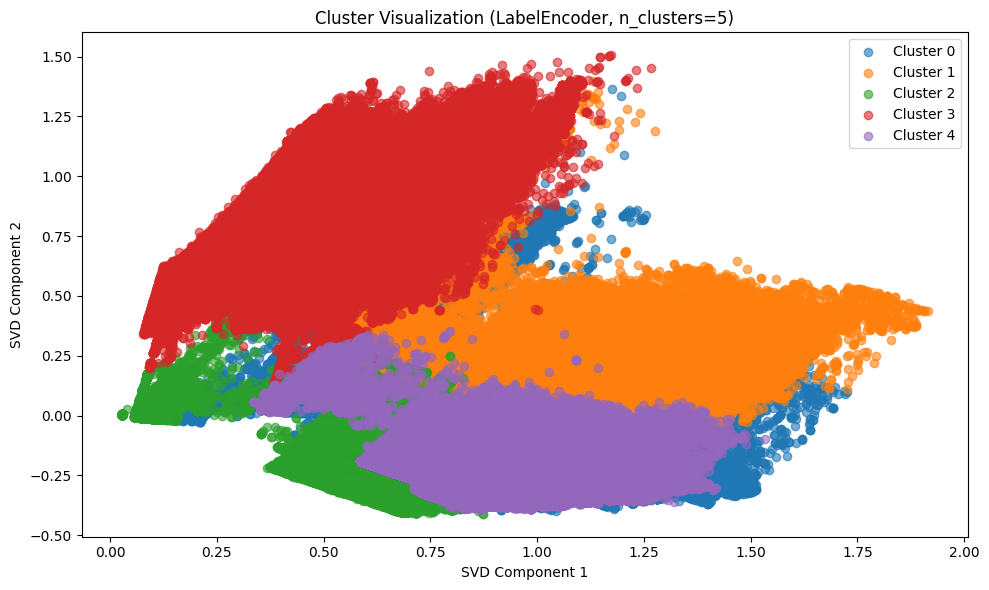


Running MiniBatchKMeans for LabelEncoder with k=10...


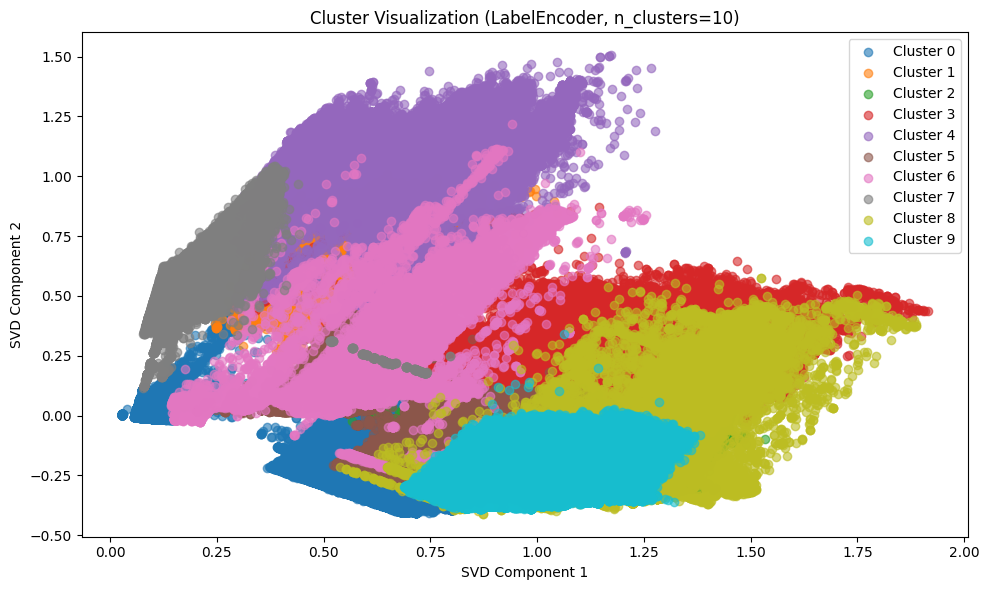


Running MiniBatchKMeans for LabelEncoder with k=15...


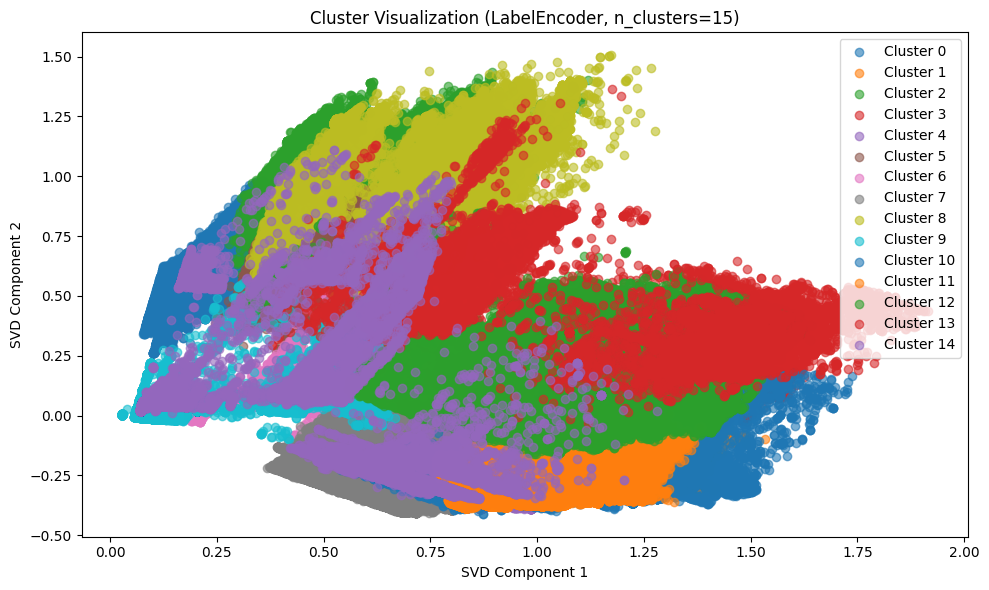


Running MiniBatchKMeans for LabelEncoder with k=20...


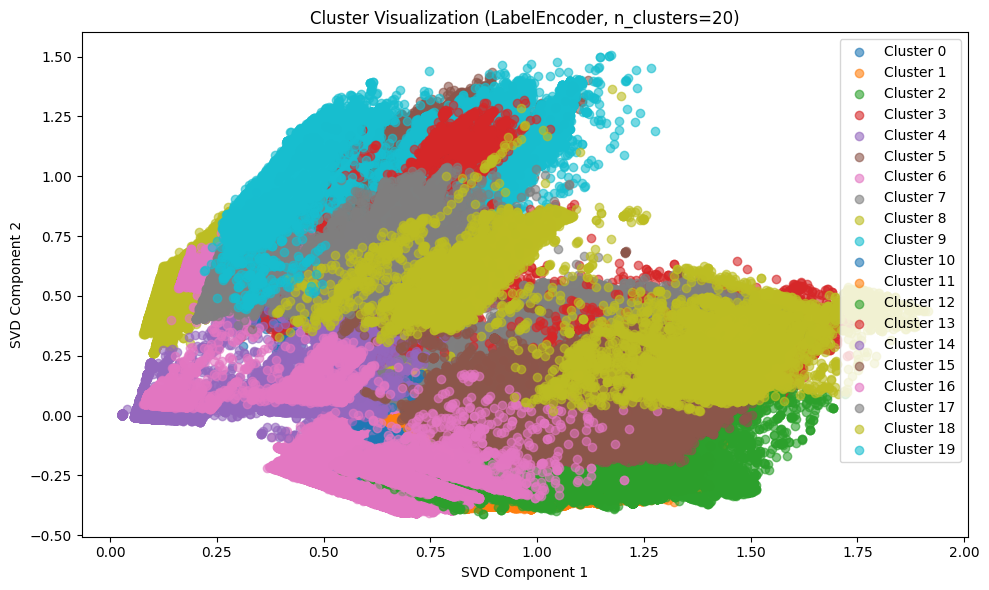


Running MiniBatchKMeans for FeatureHasher with k=5...


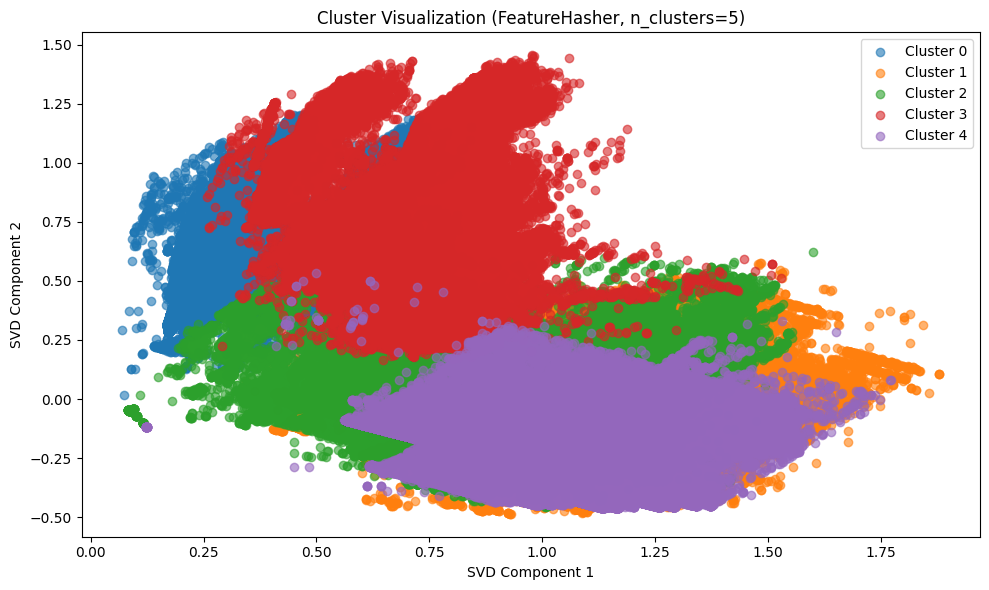


Running MiniBatchKMeans for FeatureHasher with k=10...


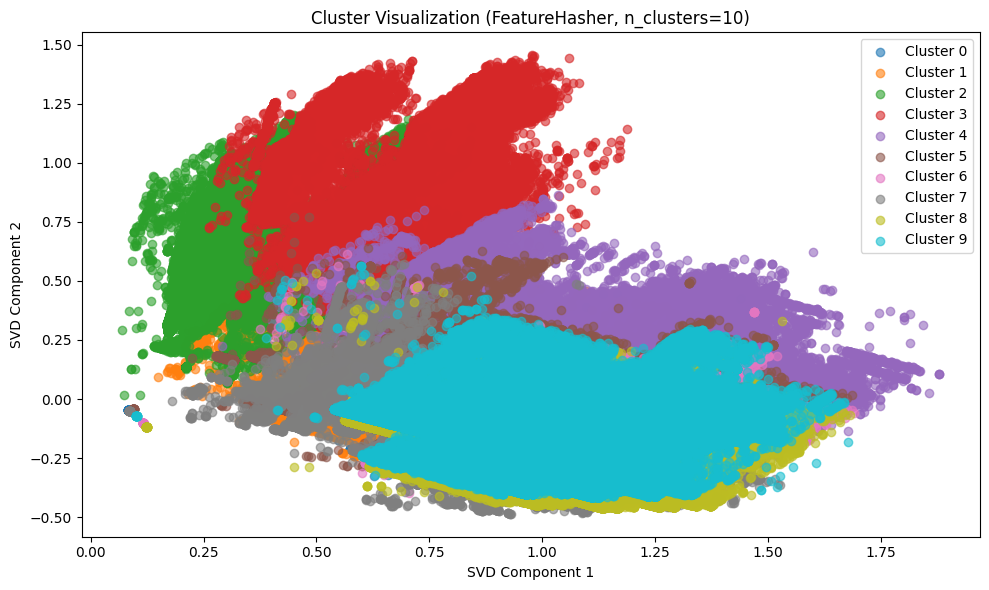


Running MiniBatchKMeans for FeatureHasher with k=15...


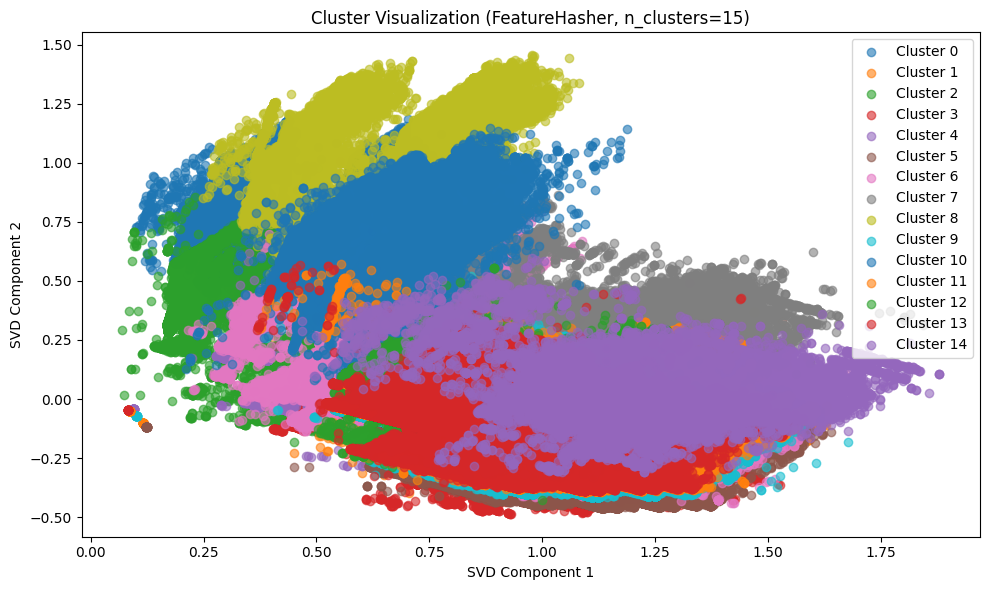


Running MiniBatchKMeans for FeatureHasher with k=20...


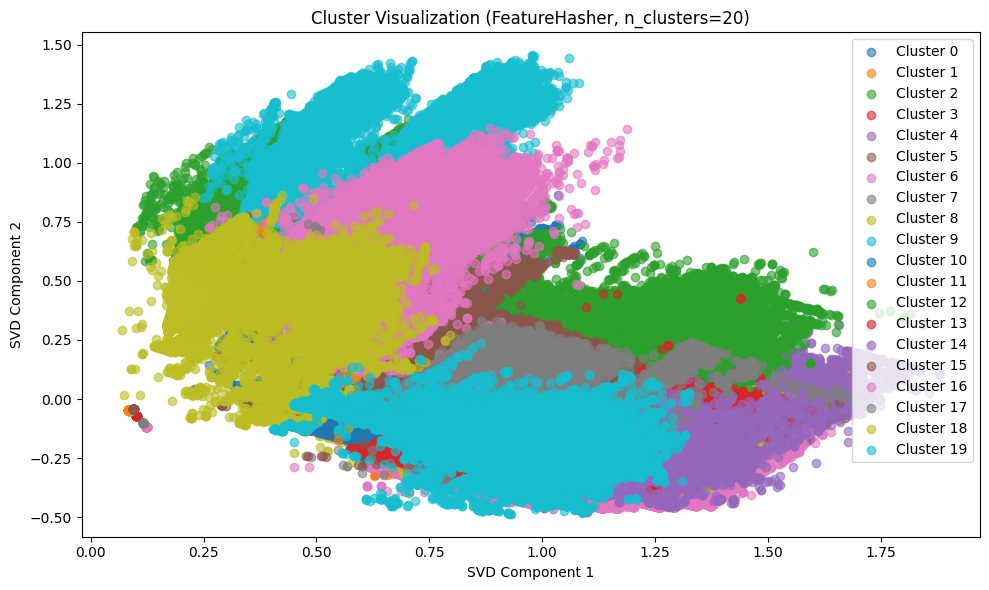


✅ Comparison Completed ✅
   Encoding Type  Clusters (k)  Silhouette Score  Davies-Bouldin Index  \
0   LabelEncoder             5          0.400014              0.988009   
1   LabelEncoder            10          0.390432              1.097559   
2   LabelEncoder            15          0.399865              1.098623   
3   LabelEncoder            20          0.345877              1.205726   
4  FeatureHasher             5          0.275766              1.571452   
5  FeatureHasher            10          0.433507              1.010200   
6  FeatureHasher            15          0.478176              0.830014   
7  FeatureHasher            20          0.470751              0.956500   

   Calinski-Harabasz Index  Adjusted Rand Index (ARI)  \
0              2273.840482                   0.014332   
1              2274.965839                   0.080160   
2              2313.614446                   0.092385   
3              2044.017137                   0.077573   
4              1065.44

In [ ]:
######################################################################################################################
# Perform clustering by ecoder type
# Visualize Clusters
######################################################################################################################
results = []

for encoder_name, X in datasets.items():
    for k in [5, 10, 15, 20]:
        print(f"\nRunning MiniBatchKMeans for {encoder_name} with k={k}...")

        sample_size = min(300000, len(X))
        X_sample, _, y_sample, _ = train_test_split(X, y_true, train_size=sample_size, random_state=42)

        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=5000, max_iter=50, n_init=3)
        kmeans.fit(X_sample)

        cluster_labels = kmeans.predict(X)
        plot_clusters(X, cluster_labels, k, encoder_name)

        X_train, X_temp, y_train, y_temp, c_train, c_temp = train_test_split(X, y_true, cluster_labels, test_size=0.3, random_state=42)
        X_test, X_val, y_test, y_val, c_test, c_val = train_test_split(X_temp, y_temp, c_temp, test_size=1/3, random_state=42)
        X_eval = np.vstack([X_test, X_val])
        y_eval = np.hstack([y_test, y_val])
        cluster_eval = np.hstack([c_test, c_val])

        result = evaluate_clustering(X_eval, y_eval, cluster_eval, encoder_name, k, kmeans)
        results.append(result)

# --- Save all results ---
results_df = pd.DataFrame(results)
results_df.to_csv('clustering_results_comparison.csv', index=False)

print("\n Comparison Completed ")
print(results_df)
print("\nResults saved to clustering_results_comparison.csv")

In [ ]:
######################################################################################################################
# Write Results Table to CSV file
######################################################################################################################

#results_df.to_csv('results_full_table.csv', index=False)

results_df.columns

Index(['Encoding Type', 'Clusters (k)', 'Silhouette Score',
       'Davies-Bouldin Index', 'Calinski-Harabasz Index',
       'Adjusted Rand Index (ARI)', 'Normalized Mutual Information (NMI)',
       'Fowlkes-Mallows Index (FMI)', 'Homogeneity', 'Completeness',
       'V-measure', 'True Positives (TP)', 'False Positives (FP)',
       'False Negatives (FN)', 'True Negatives (TN)', 'Inertia'],
      dtype='object')

# **Section 5: Display Visulizations**

In [ ]:
######################################################################################################################
# Print Results Table
######################################################################################################################

print("\nClustering Results:")
print(results_df)


Clustering Results:
   Encoding Type  Clusters (k)  Silhouette Score  Davies-Bouldin Index  \
0   LabelEncoder             5          0.400014              0.988009   
1   LabelEncoder            10          0.390432              1.097559   
2   LabelEncoder            15          0.399865              1.098623   
3   LabelEncoder            20          0.345877              1.205726   
4  FeatureHasher             5          0.275766              1.571452   
5  FeatureHasher            10          0.433507              1.010200   
6  FeatureHasher            15          0.478176              0.830014   
7  FeatureHasher            20          0.470751              0.956500   

   Calinski-Harabasz Index  Adjusted Rand Index (ARI)  \
0              2273.840482                   0.014332   
1              2274.965839                   0.080160   
2              2313.614446                   0.092385   
3              2044.017137                   0.077573   
4              1065.445919 

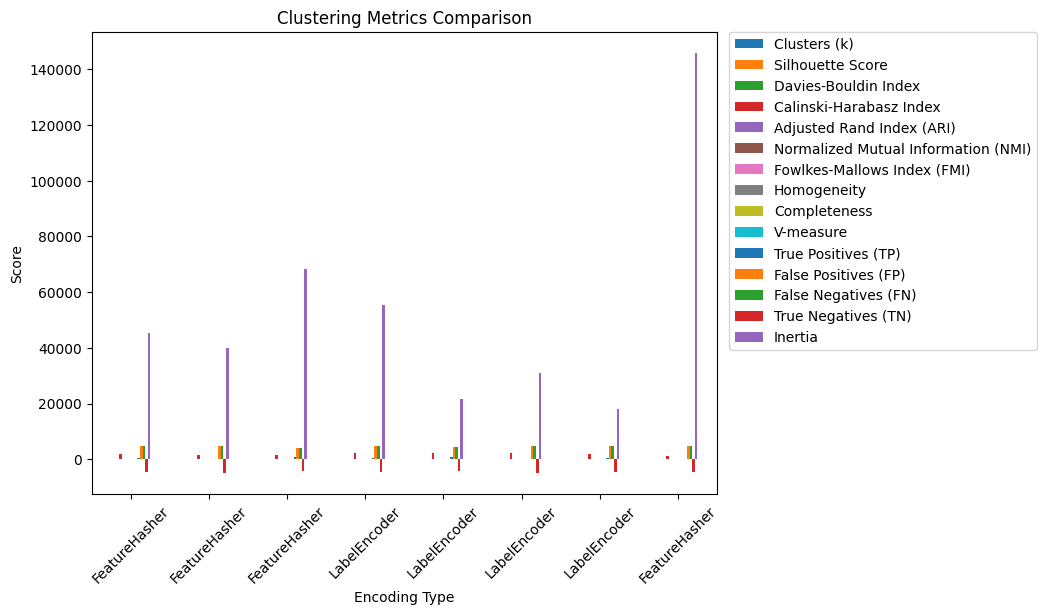

In [ ]:
#####################################################################################################################
# Display Visualizations
######################################################################################################################

# Plot evaluation metrics
plot_metrics(results_df)

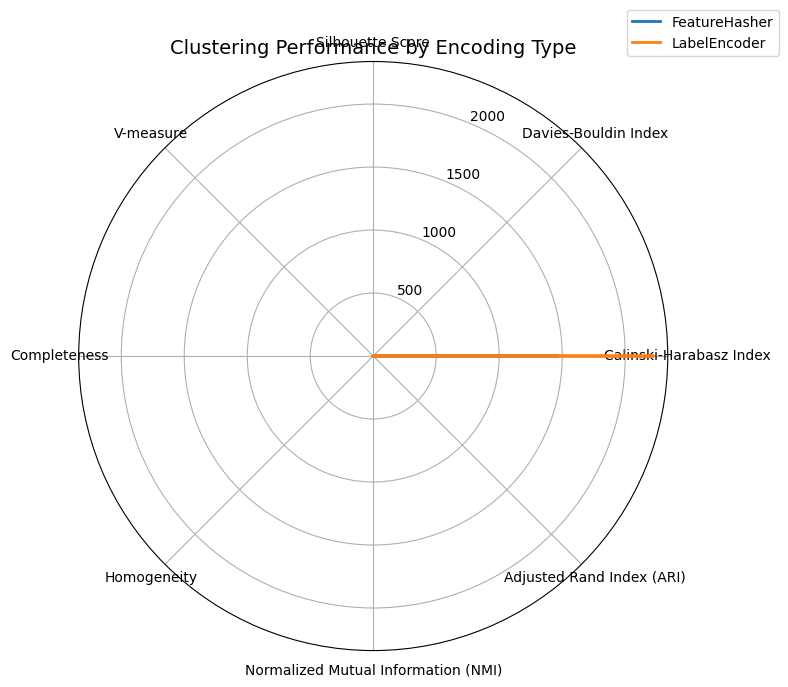

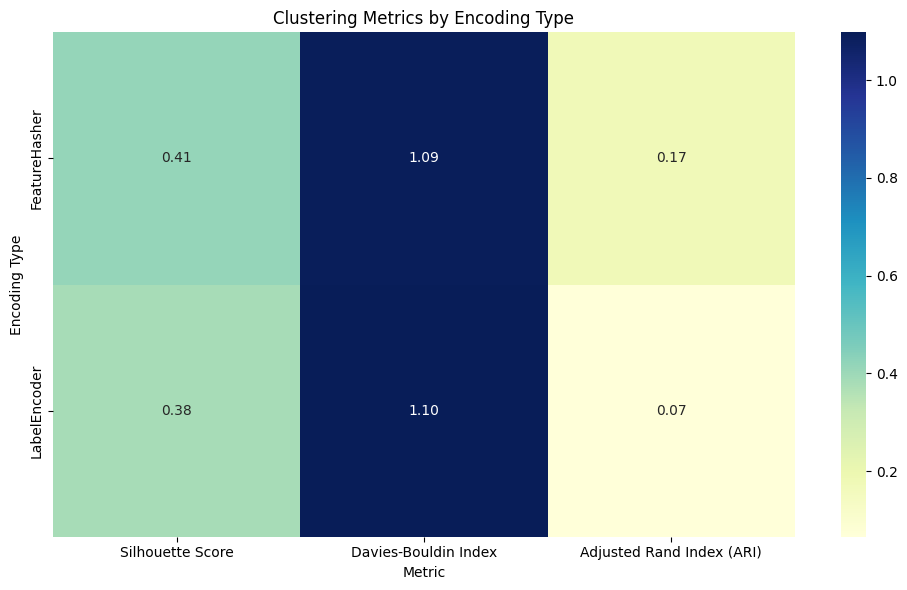

In [ ]:
######################################################################################################################
# Visualization of Radar graph and Heatmap

# Radar graph
# Call the radar chart plotting function to visually compare clustering performance
# across multiple encoding types and evaluation metrics.
# This chart is especially useful for seeing how each encoding performs relative to others
# across several dimensions like Silhouette Score, ARI, Homogeneity, etc.
# Heatmap
# Call the heatmap plotting function to display a grid of average metric scores
# for each encoding type. This provides a quick, at-a-glance comparison of performance
# using color intensity and numerical values.
# Ideal for identifying strong or weak encodings for specific metrics.
######################################################################################################################

plot_radar_metrics(results_df)
plot_heatmap(results_df)

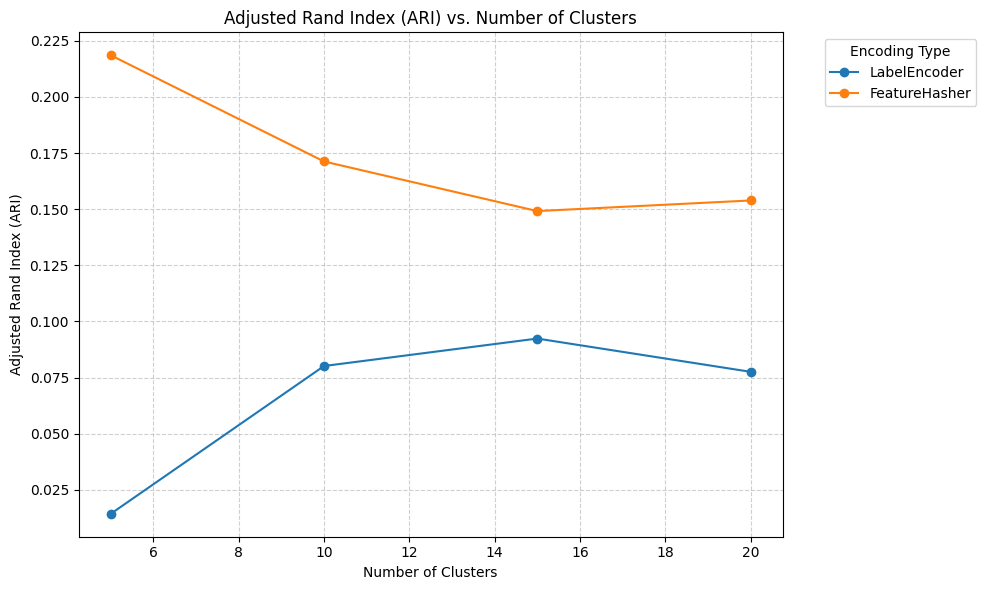

In [ ]:
######################################################################################################################
# Call visualization of Metrics over Clusters Function
# Plot how evaluation metric changes as the number of clusters increases, for each encoding type.
######################################################################################################################

plot_metric_over_clusters(results_df, metric='Adjusted Rand Index (ARI)')

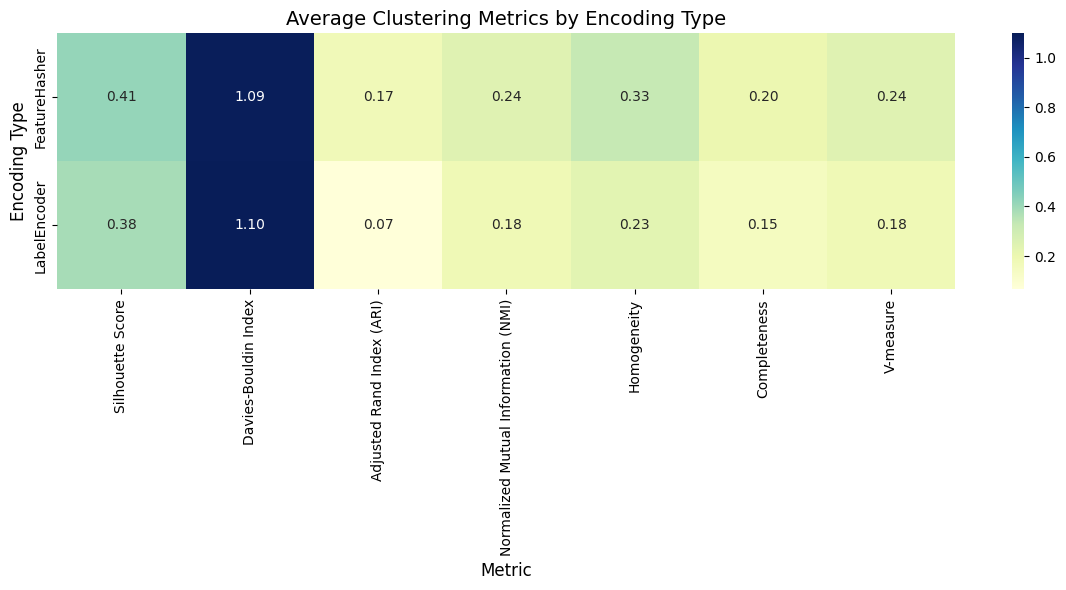

In [ ]:
######################################################################################################################
# Visualization of Encoder Heatmap
# Plot the heatmap using seaborn
# - annot=True: show metric values in the heatmap cells
# - fmt=".2f": format numbers to 2 decimal places
# - cmap="YlGnBu": color map from yellow to green to blue
# - cbar=True: display color bar legend
######################################################################################################################

plot_encoder_metric_heatmap(results_df)

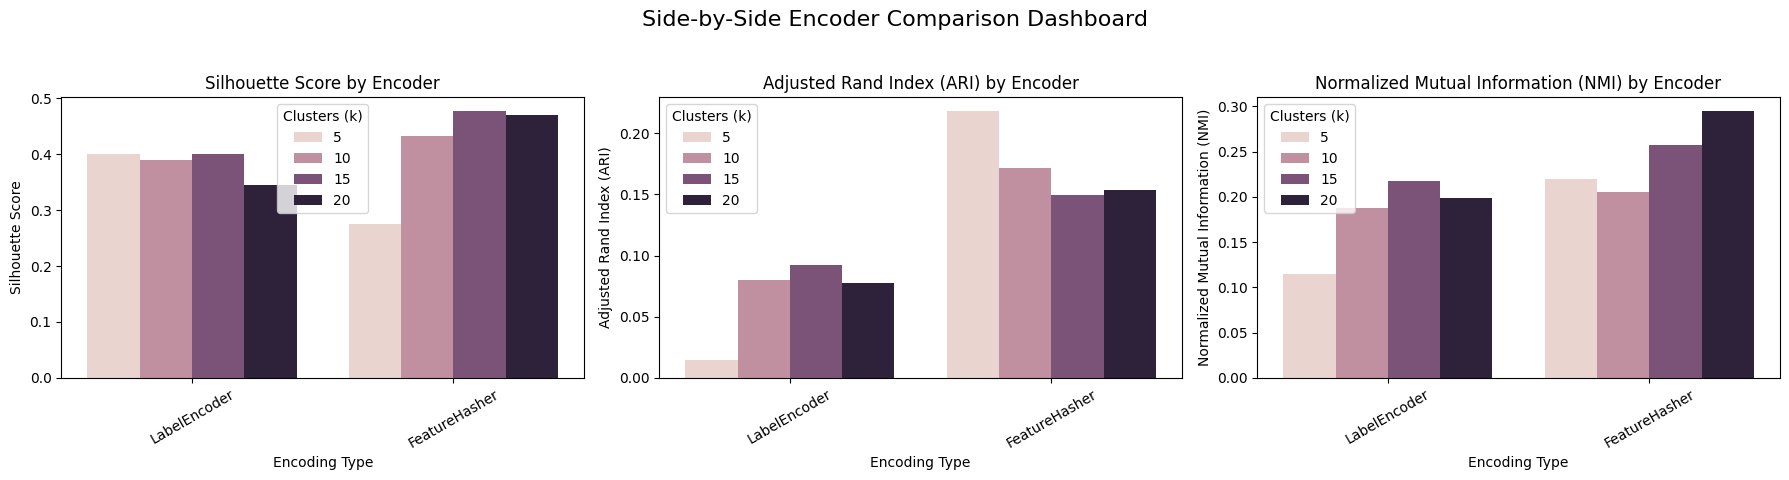

In [ ]:
######################################################################################################################
# Visualization of Encoder Comparison Dashboard
# Use seaborn to plot a bar chart for the current metric
# - x: Encoding Type
# - y: Metric value
# - hue: n_clusters to show performance variation by cluster count
######################################################################################################################

plot_encoder_comparison_dashboard(results_df)

In [ ]:
######################################################################################################################
# Visualization of Leaderboard Table
# Call visualizaton of leaderboard function
# Create metrics list
# Disply Leaderboaed Table
######################################################################################################################

metrics = [
    'Silhouette Score',
    'Davies-Bouldin Index',
    'Adjusted Rand Index (ARI)',
    'Normalized Mutual Information (NMI)',
    'Homogeneity',
    'Completeness',
    'V-measure'
]

leaderboard_df = results_df.groupby('Encoding Type')[metrics].mean()
print("Leaderboard (average across n_clusters):")
print(leaderboard_df.round(3))

Leaderboard (average across n_clusters):
               Silhouette Score  Davies-Bouldin Index  \
Encoding Type                                           
FeatureHasher             0.415                 1.092   
LabelEncoder              0.384                 1.097   

               Adjusted Rand Index (ARI)  Normalized Mutual Information (NMI)  \
Encoding Type                                                                   
FeatureHasher                      0.173                                0.245   
LabelEncoder                       0.066                                0.179   

               Homogeneity  Completeness  V-measure  
Encoding Type                                        
FeatureHasher        0.328         0.200      0.245  
LabelEncoder         0.234         0.148      0.179  


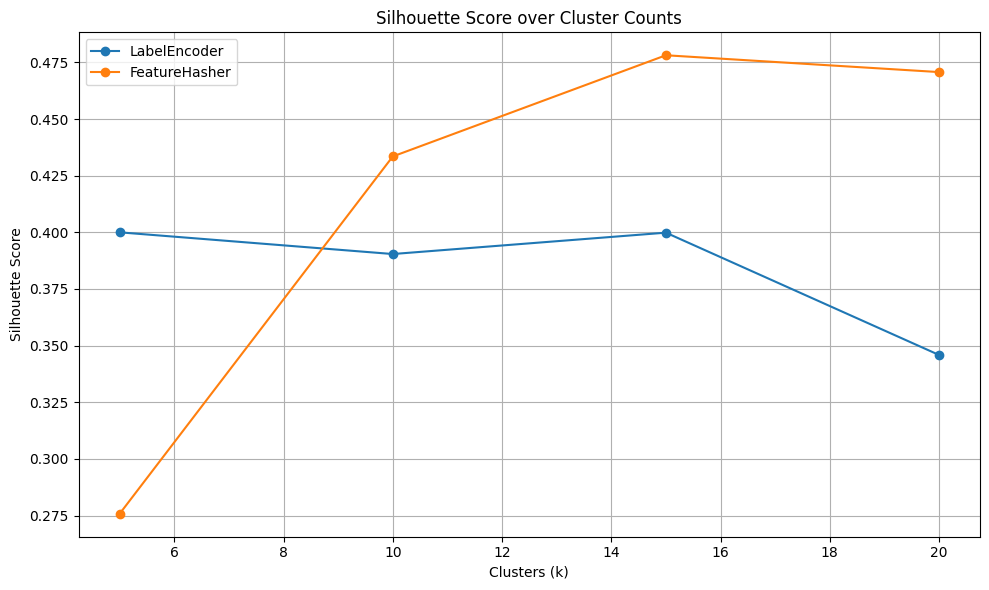

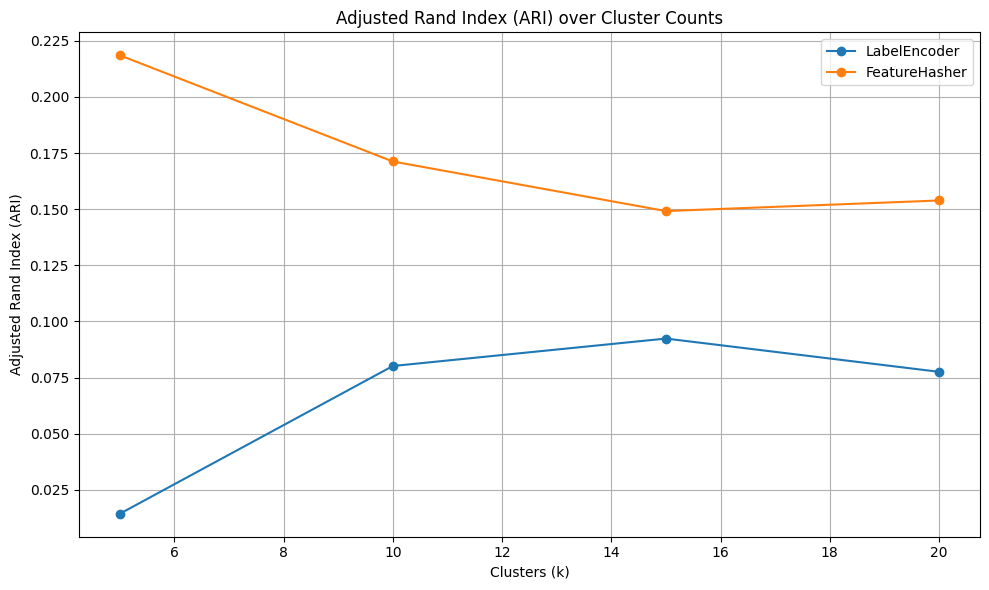

In [ ]:
######################################################################################################################
# Visualization of Metric Trends
# Plot the metric values against the number of clusters
# Use markers to emphasize each point and label the line with the encoding name
######################################################################################################################

plot_metric_trends(results_df, metric='Silhouette Score')
plot_metric_trends(results_df, metric='Adjusted Rand Index (ARI)')

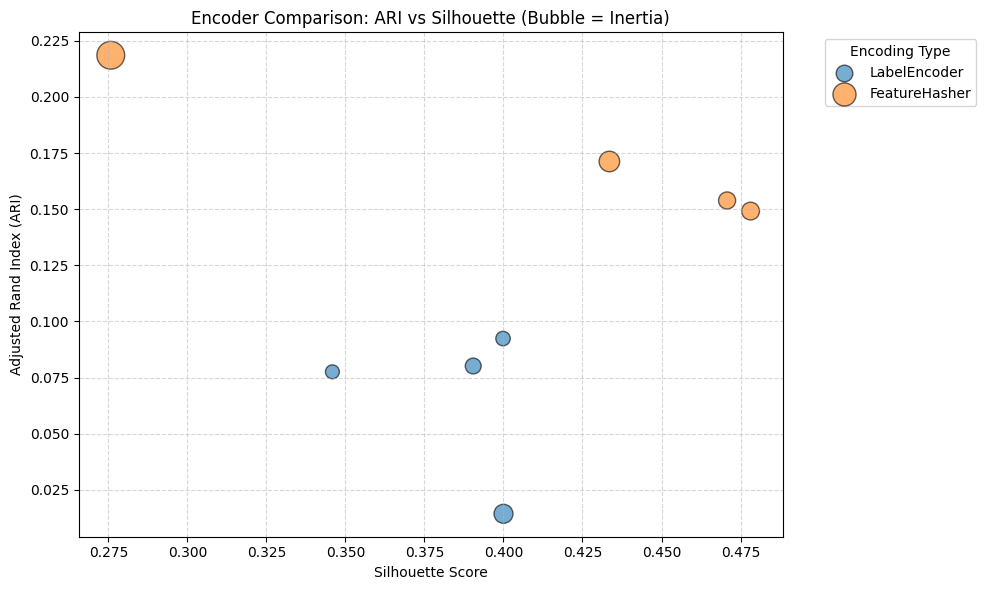

In [ ]:
######################################################################################################################
# Visualization of Bubble Chart
#    Creates a bubble chart with:
#        X-axis = Silhouette Score
#        Y-axis = Adjusted Rand Index
#        Bubble size = normalized Inertia
######################################################################################################################

plot_bubble_chart(results_df)

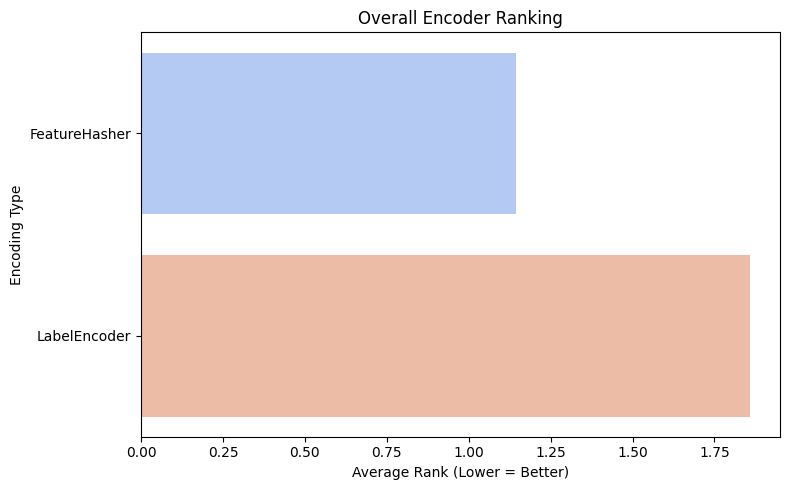

In [ ]:
######################################################################################################################
# Visualization of Encoder Ranking
# Plot a horizontal bar chart of average ranks
# Lower values (top of the chart) represent better-performing encodings
######################################################################################################################

plot_encoder_ranking(results_df, metrics)

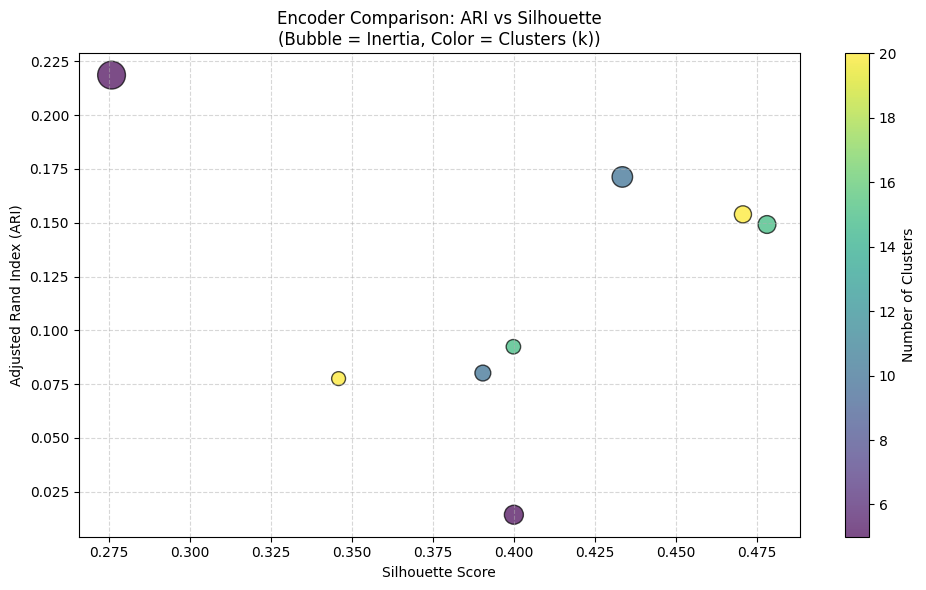

In [ ]:
######################################################################################################################
# Visualization of Bubble Chart with Cluster Gradient
#    Bubble chart:
#    - X-axis: Silhouette Score
#    - Y-axis: Adjusted Rand Index (ARI)
#    - Bubble size: normalized Inertia
#    - Color: gradient based on n_clusters

######################################################################################################################

plot_bubble_chart_with_cluster_gradient(results_df)

# **Section 8: Analyze Results**


Sample Source.IP to Cluster to Label mapping:
        Source.IP  Cluster                                              label  \
0    10.120.1.191       10                                           [Browse]   
1    10.120.1.191       19                                        [eCommerce]   
2    10.130.1.139       10                                           [Browse]   
3   10.130.10.101       10                                           [Browse]   
4   10.130.10.101       19                                [Email & Messaging]   
5   10.130.10.158       10                                           [Browse]   
6   10.130.10.176       10                                           [Browse]   
7   10.130.10.191       10                                           [Browse]   
8   10.130.10.191       14                                        [eCommerce]   
9   10.130.10.191       19  [Productivity, Infrastructure mgmt, Email & Me...   
10  10.130.10.215       10                                    

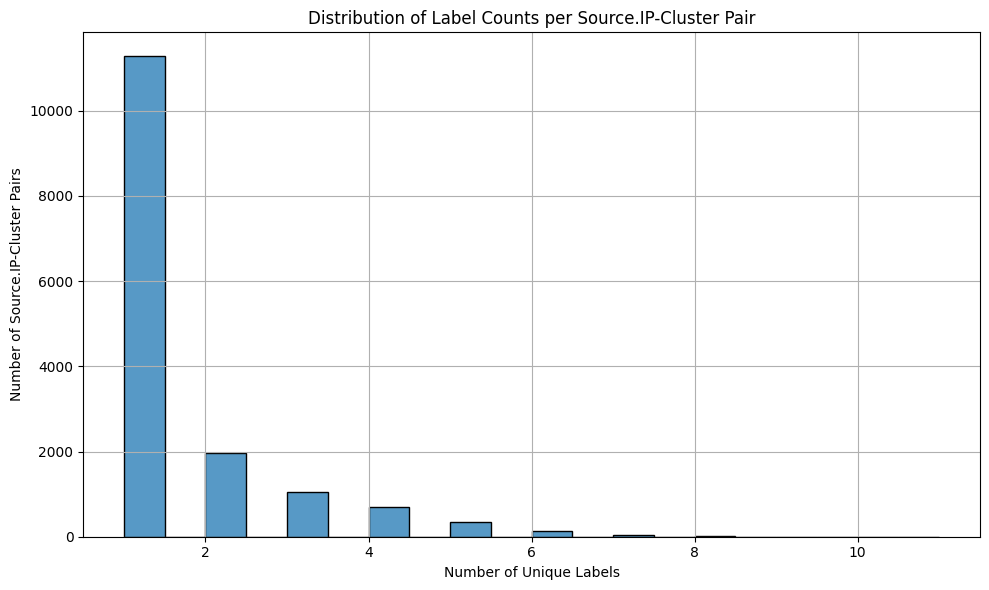


✅ Saved pure and impure Source.IPs:
-pure_source_ips.csv
-impure_source_ips.csv


In [ ]:
######################################################################################################################
# Plot Distribution of Label Counts per Source.IP-Cluster and Analyze Purity
######################################################################################################################
df_with_clusters = df_0.copy()
df_with_clusters['Cluster'] = cluster_labels

# --- Step 2: Group by Source.IP and Cluster, collect all labels ---
ip_cluster_label_map = df_with_clusters.groupby(['Source.IP', 'Cluster'])['label'].unique().reset_index()

# Add a count of how many different labels per IP per Cluster
ip_cluster_label_map['Label_Count'] = ip_cluster_label_map['label'].apply(len)

# Display first few rows
print("\nSample Source.IP to Cluster to Label mapping:")
print(ip_cluster_label_map.head(20))

# --- Step 3: Analyze Purity ---
pure_ips = ip_cluster_label_map[ip_cluster_label_map['Label_Count'] == 1]
impure_ips = ip_cluster_label_map[ip_cluster_label_map['Label_Count'] > 1]

total_ips = len(ip_cluster_label_map)
pure_count = len(pure_ips)
impure_count = len(impure_ips)
purity_percentage = 100 * pure_count / total_ips

print(f"\nTotal Source.IP-Cluster pairs: {total_ips}")
print(f"Pure IPs (only 1 label inside cluster): {pure_count}")
print(f"Impure IPs (multiple labels inside cluster): {impure_count}")
print(f"Purity Rate: {purity_percentage:.2f}%")

# --- Step 4: Save results to CSV ---
ip_cluster_label_map.to_csv('source_ip_cluster_labels_map.csv', index=False)
print("Saved Source.IP to Cluster to Label Mapping to source_ip_cluster_labels_map.csv")

# --- Step 5: Plot Distribution of Label Counts per Source.IP-Cluster pair ---
plt.figure(figsize=(10,6))
sns.histplot(ip_cluster_label_map['Label_Count'], bins=20, kde=False)
plt.title('Distribution of Label Counts per Source.IP-Cluster Pair')
plt.xlabel('Number of Unique Labels')
plt.ylabel('Number of Source.IP-Cluster Pairs')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Optional: Save Pure and Impure lists separately if needed ---
pure_ips.to_csv('pure_source_ips.csv', index=False)
impure_ips.to_csv('impure_source_ips.csv', index=False)

print("\Saved pure and impure Source.IPs:")
print("pure_source_ips.csv")
print("impure_source_ips.csv")


Normalized Crosstab (Percentages by Label):
Cluster                       0     1      2      3      4      5      6   \
label                                                                       
Authenticated Browse        0.02  0.02   2.13  14.74   0.65  21.31  19.94   
Browse                      3.22  1.77  25.49   2.50   0.03   0.00   3.00   
Cloud Storage               0.43  2.25   3.95   4.06   7.94   5.61   4.82   
Email & Messaging           2.34  2.89   0.86   7.83  13.28   9.57  12.09   
File Transfer & Streaming   2.20  1.67   2.79  14.02   3.72  11.15  10.15   
Infrastructure mgmt         0.07  0.15   1.13   8.69   1.68   6.58   9.98   
Monitoring                  0.36  0.15   0.15   1.44   0.05   2.21   2.31   
Productivity                1.67  0.92   0.77   6.79   8.06   6.56   8.39   
Social Media                3.73  2.48   0.60   7.83   9.77  10.64  10.17   
Unknown                    22.43  7.48   0.00   3.74   2.80   0.00   6.54   
eCommerce                   2.7

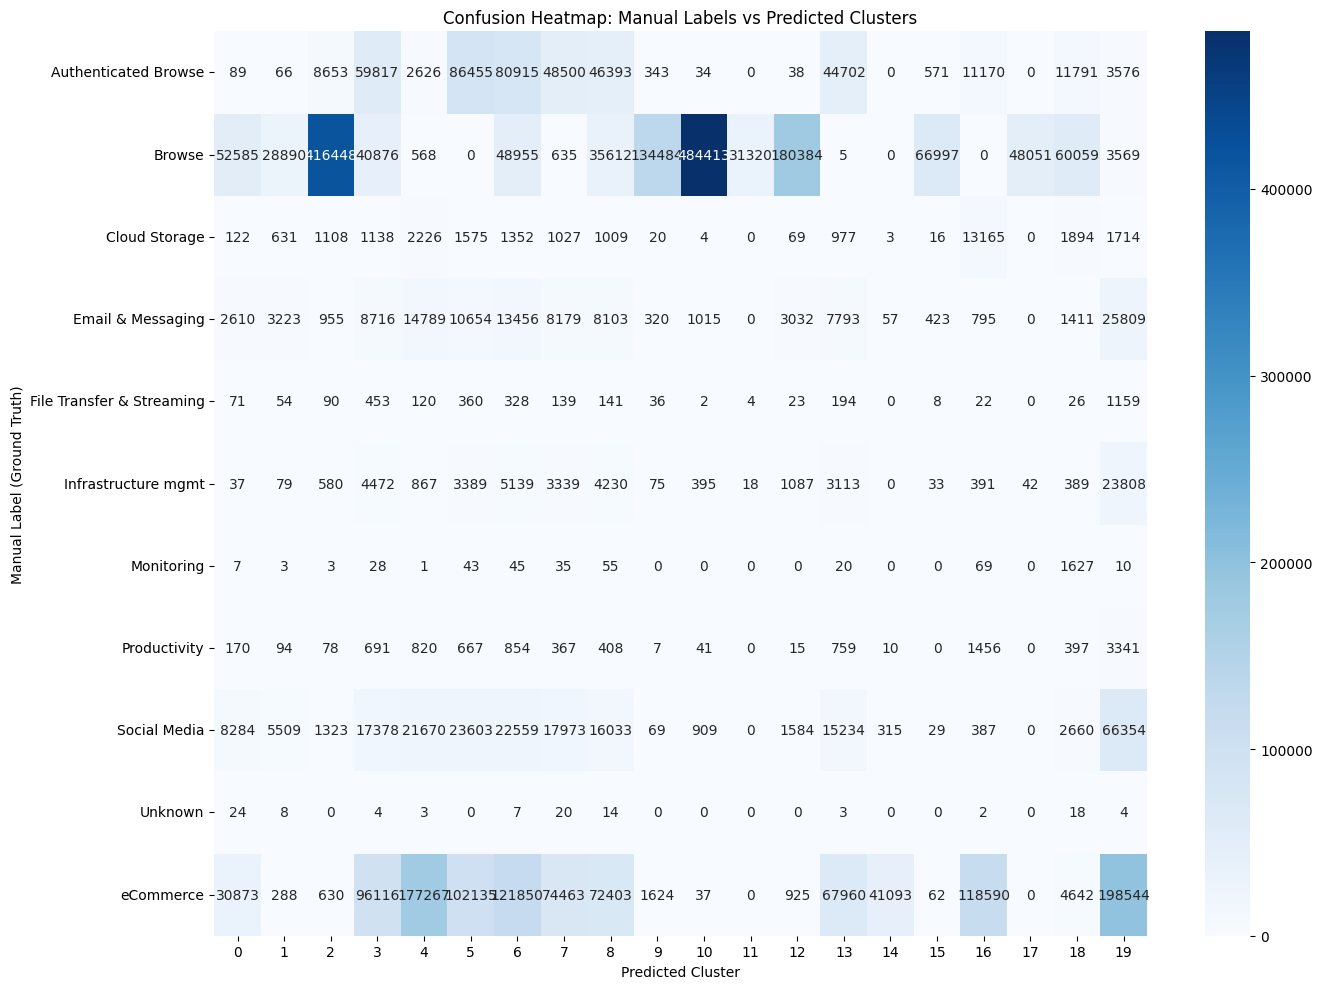

In [ ]:
######################################################################################################################
# Create Heatmap and distribution between manual labeling and optimal Kmeans clustering
######################################################################################################################
df_with_clusters = df_0.copy()
df_with_clusters['Cluster'] = cluster_labels
# --- Confusion Table: Source Manual Labels vs Predicted Clusters ---

# Ground truth (manual labels)
y_true = df_with_clusters['label']

# Predicted clusters
y_pred = df_with_clusters['Cluster']

# Create crosstab
# Confusion_crosstab = pd.crosstab(y_true, y_pred)
# Confusion_crosstab = pd.crosstab(df_with_clusters['label'], df_with_clusters['Cluster'])
# Normalize the crosstab by row (i.e., by manual label)
confusion_crosstab_normalized = confusion_crosstab.div(confusion_crosstab.sum(axis=1), axis=0) * 100

# Display normalized crosstab
print("\nNormalized Crosstab (Percentages by Label):")
print(confusion_crosstab_normalized.round(2))

# Display
print("\nManual Labels vs Predicted Clusters (Crosstab):")
print(confusion_crosstab)

# 📈 Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(confusion_crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Heatmap: Manual Labels vs Predicted Clusters')
plt.xlabel('Predicted Cluster')
plt.ylabel('Manual Label (Ground Truth)')
plt.tight_layout()
plt.show()



# **END**